# -*- coding: utf-8 -*-
**Pipeline for spectral analysis using LW-PLS in Google Colab.**

This script implements a complete Local-Weighted Partial Least Squares (LW-PLS) workflow for spectral analysis of samples with metadata. The process consists of:

1. **Data loading from an Excel file** (one sheet per spectrum type).
2. **Metadata filtering** (DiaAnalysis, Species, Breed).
3. **Raw Spectra Visualization** (optional) with conditional saving.
4. **Outlier processing** (Winsorization) and NaN removal.
5. **Savitzky–Golay smoothing**.
6. **Processed Spectra Visualization** (optional) with conditional saving.
7. **Training/test split** stratified by Species–Breed.
8. **Z-score normalization** of X (spectra), Y (target variable), and Z (covariates).
9. **Visualization** of normalized spectra (optional).
10. **Training and evaluating** LW-PLS models for each spectra, with optional cross-validation tuning.
11. **Conditional saving** of LW-PLS plots (optional).
12. **Fusing** components from each spectra into a PLS meta-model.
13. **Conditional saving** of the Fusion plot (optional).

In [ ]:
## Section 1. Mount Drive and setup imports

import os
try:
    from google.colab import drive
except ImportError:
    drive = None
import sys

# Mount Google Drive
if not os.path.isdir('/content/drive'):
    drive.mount('/content/drive')

# LW_PLS function Path
ruta_lwpls = '/content/drive/MyDrive/Xavi/LW_PLS'
if ruta_lwpls not in sys.path:
    sys.path.insert(0, ruta_lwpls)

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
import importlib
from lwpls import lwpls  # make sure lwpls.py is in your working directory

Mounted at /content/drive


In [ ]:
# Section 2. User parameters and Load Data

# Path to your Excel file in Drive
EXCEL_PATH = '/content/drive/MyDrive/Xavi/Experimental1_Data_Compiled.xlsx'

# Sheets to analyze (list of sheet names, e.g.: ['Vis', 'NIR', 'F_290'])
sheets = ['Vis', 'NIR', 'F_290', 'F_298_BeforeBreaking',
          'F_298_AfterRepairing', 'F_310', 'F_330', 'F_340']  # List of sheets to process

# Spectral ranges for each sheet (column indices relative to the spectrum start)
# Use slice(None) to include all columns, or provide a list of zero-based indices
spec_ranges = {
    'Vis': list(range(734, 2871)),                        # from 390 - 930 nm
    'NIR': list(range(0, 207)),                           # from 900 - 1900 nm
    'F_290': list(range(4, 447)),                         # from 252 - 600 nm
    'F_298_BeforeBreaking': list(range(4, 777)),          # from 252 - 850 nm
    'F_298_AfterRepairing': list(range(4, 447)),          # from 252 - 600 nm
    'F_310': list(range(4, 421)),                         # from 252 - 580 nm
    'F_330': list(range(4, 50)) + list(range(126, 512)),  # from 252 - 288 nm + 349 - 650 nm
    'F_340': list(range(4, 60)) + list(range(135, 512)),  # from 252 - 296 nm + 356 - 650 nm
}

# Select the position where the spectra starts in each sheet
start_idx_map = {'Vis': 24, 'NIR': 24}
default_start_idx = 30

# Select the important columns that you want to take in account
META_COLS = ['Fat','Protein','DiaAnalysis','Temp','Especie','Raza']

# Metadata filters (set lists to select, or use empty list [] to include all)
# DiaAnalysis values to filter (0, 1, 2, 3)
dia_values = [0, 1, 2, 3]  # Only include these DiaAnalysis values

# Species to filter (e.g.: ['Cabra', 'Oveja', 'Mezcla'])
species_values = ['Cabra', 'Oveja', 'Mezcla']  # Only include these species

# Breeds to filter (e.g.: ['MurcianoGranadina', 'Lacaune', 'Manchega', 'Tanque', 'Mezcla'])
breed_values = ['MurcianoGranadina', 'Lacaune', 'Manchega', 'Tanque', 'Mezcla']  # Only include these breeds

raw_data = {}

for sheet in sheets:
    # 1) Leer hoja
    df = pd.read_excel(EXCEL_PATH, sheet_name=sheet)

    # 2) Determinar dónde comienzan las columnas espectrales
    start_idx = start_idx_map.get(sheet, default_start_idx)
    spec_cols_all = df.columns[start_idx:]

    # 3) Extraer solo las columnas de metadatos
    df_meta = df[META_COLS]

    # 4) Validar y seleccionar el bloque espectral definido en spec_ranges
    sel = spec_ranges.get(sheet, [])
    if not isinstance(sel, (list, slice)):
        raise ValueError(f"spec_ranges['{sheet}'] debe ser lista de índices o slice, no {type(sel)}")
    if isinstance(sel, list):
        n_cols = len(spec_cols_all)
        if sel:  # sólo si la lista no está vacía
            min_idx, max_idx = min(sel), max(sel)
            if min_idx < 0 or max_idx >= n_cols:
                raise ValueError(
                    f"spec_ranges['{sheet}'] contiene índices fuera de rango "
                    f"(deben estar entre 0 y {n_cols-1}): {sel}"
                )
        spec_cols = spec_cols_all[sel]
    else:
        # en caso de slice, pandas lo maneja internamente
        spec_cols = spec_cols_all[sel]

    # 5) Extraer datos espectrales y concatenar con metadatos
    df_spec = df.loc[:, spec_cols]
    df_sub  = pd.concat([df_meta, df_spec], axis=1)

    # 6) Filtrar filas según DiaAnalysis, Especie y Raza
    mask = (
        df_sub['DiaAnalysis'].isin(dia_values) &
        df_sub['Especie'].   isin(species_values) &
        df_sub['Raza'].       isin(breed_values)
    )
    df_sub = df_sub.loc[mask].reset_index(drop=True)

    # 7) Guardar en raw_data
    raw_data[sheet] = df_sub
    print(f"[CARGA] {sheet}: {len(df_sub)} filas cargadas y filtradas")

[CARGA] Vis: 1394 filas cargadas y filtradas
[CARGA] NIR: 1394 filas cargadas y filtradas
[CARGA] F_290: 172 filas cargadas y filtradas
[CARGA] F_298_BeforeBreaking: 648 filas cargadas y filtradas
[CARGA] F_298_AfterRepairing: 306 filas cargadas y filtradas
[CARGA] F_310: 1394 filas cargadas y filtradas
[CARGA] F_330: 1394 filas cargadas y filtradas
[CARGA] F_340: 1394 filas cargadas y filtradas


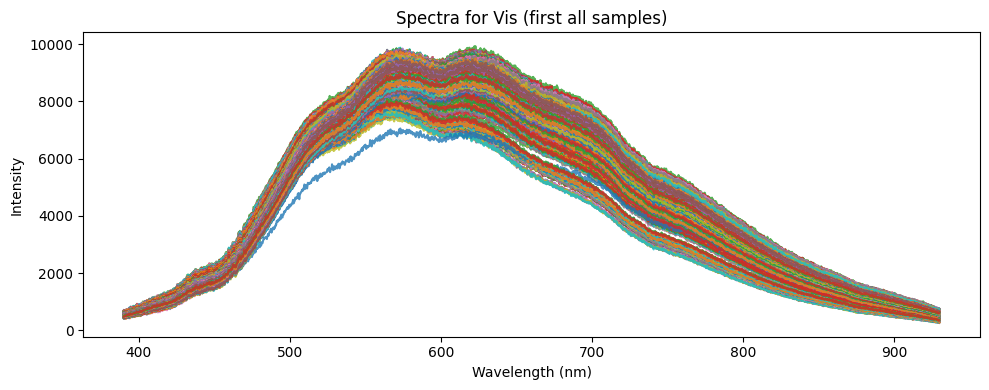

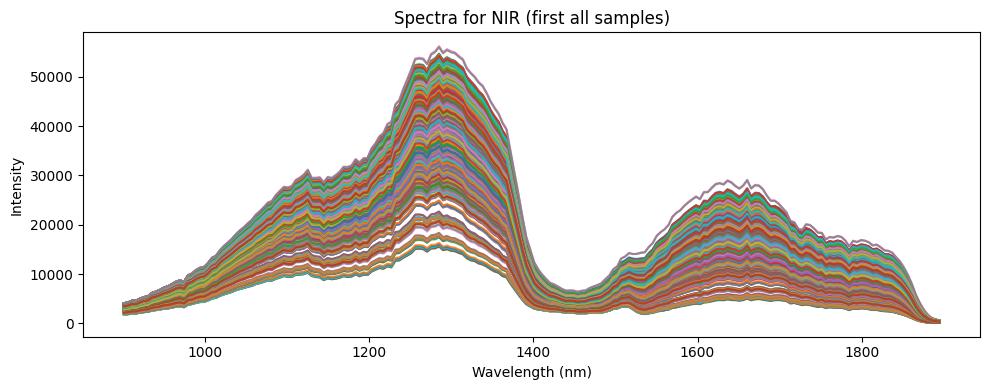

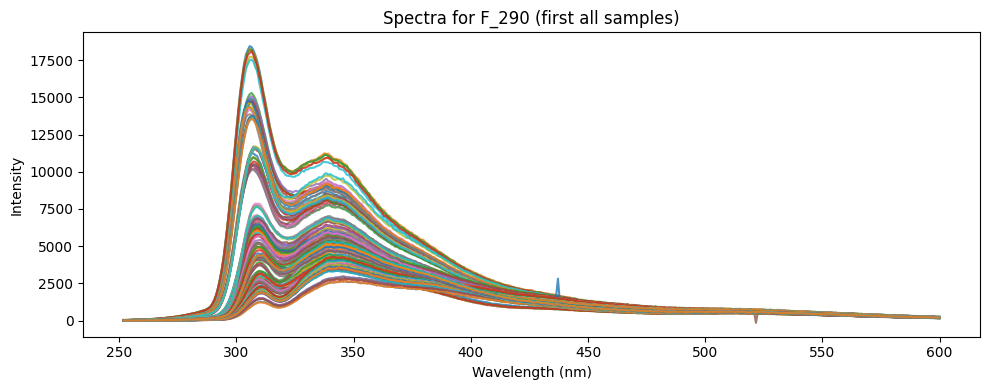

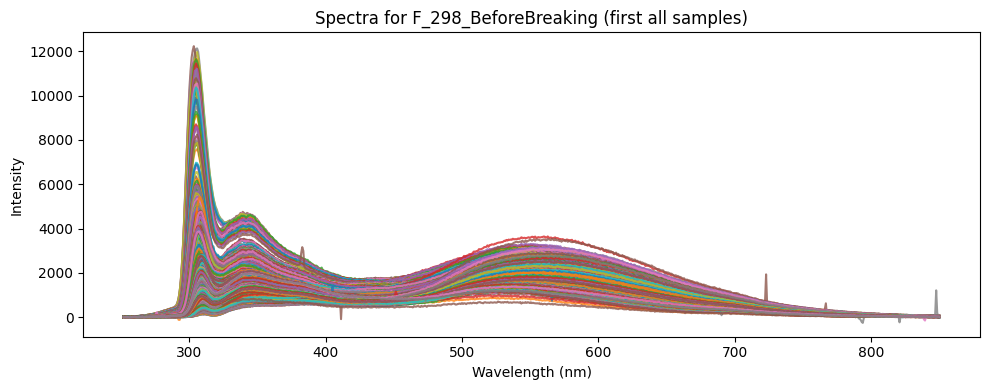

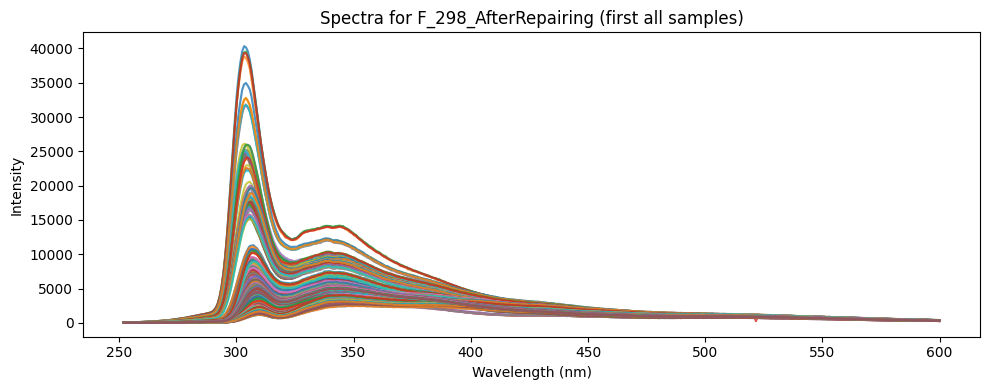

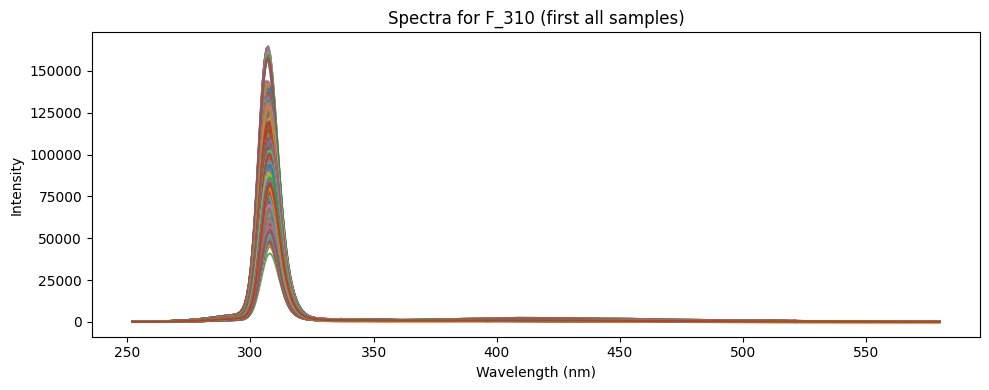

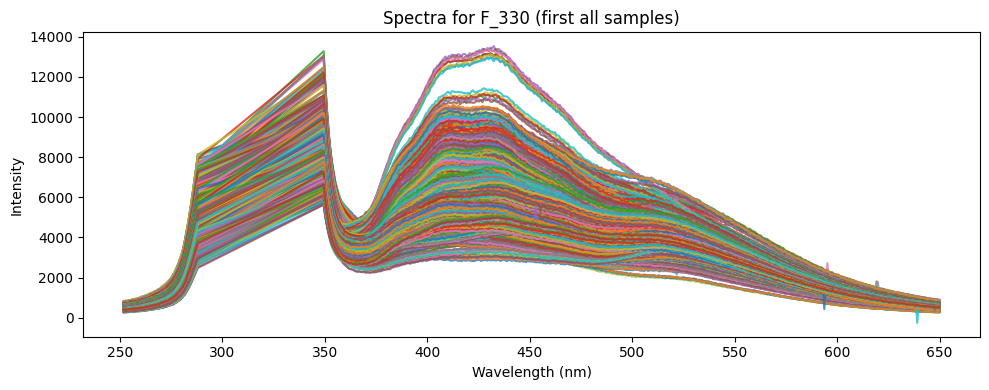

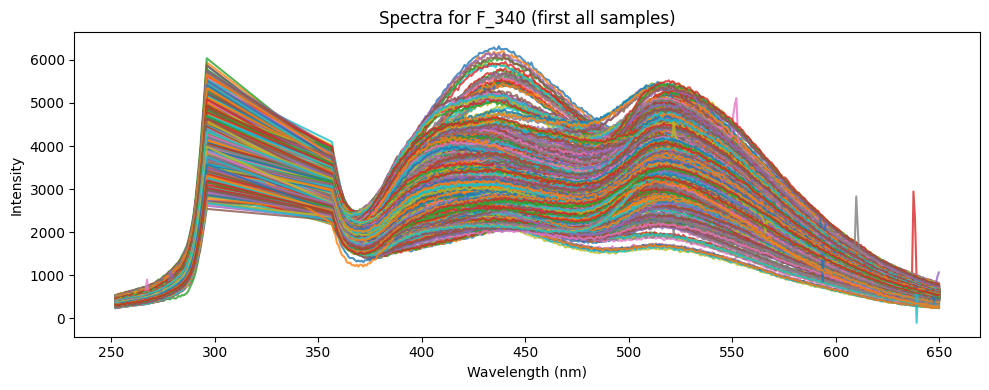

In [ ]:
# Section 3. Plot Selected spectra (Optional)

import os

# Saving Options
save_raw_plots      = True    # Put 'False' if you don't want to save the spectra
raw_plots_dir       = '/content/drive/MyDrive/Xavi/LW_PLS/Spectra_Raw'
os.makedirs(raw_plots_dir, exist_ok=True)

# Number of samples to plot per sheet (None = plot all)
plot_first_n = None

for sheet, df in raw_data.items():
    # Separate metadata vs spectrum using META_COLS
    spec_cols = [col for col in df.columns if col not in META_COLS]
    wavelengths = np.array(spec_cols, dtype=float)

    # Intensities of all samples (spectrum only)
    data_all = df[spec_cols].values.astype(float)
    data_sel = data_all.copy()

    # Limit number of spectra to plot_first_n (if not None)
    if plot_first_n is not None:
        data_sel = data_sel[:plot_first_n]

    # Plotting
    plt.figure(figsize=(10, 4))
    for y in data_sel:
        plt.plot(wavelengths, y, alpha=0.8)
    plt.title(f"Spectra for {sheet} (first {plot_first_n or 'all'} samples)")
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Intensity")
    plt.tight_layout()

    # Save plot if applicable
    if save_raw_plots:
        fname = f"{sheet}_raw.png"
        plt.savefig(os.path.join(raw_plots_dir, fname), dpi=300)
    plt.show()


In [ ]:
# Section 4 - Cleaning and Winsorization (Outlier Treatment)
import numpy as np

# Preprocessing options
apply_outlier_treatment = True    # Boolean flag: apply outlier treatment to spectra

# Winsorization (outlier treatment), define percentiles
outlier_params = {
    'Vis':    {'low_pct': 0.01, 'high_pct': 0.99},
    'NIR':    {'low_pct': 0.01, 'high_pct': 0.99},
    'F_290':  {'low_pct': 0.01, 'high_pct': 0.99},
    'F_298_BeforeBreaking':  {'low_pct': 0.01, 'high_pct': 0.99},
    'F_298_AfterRepairing':  {'low_pct': 0.01, 'high_pct': 0.99},
    'F_310':  {'low_pct': 0.01, 'high_pct': 0.99},
    'F_330':  {'low_pct': 0.01, 'high_pct': 0.99},
    'F_340':  {'low_pct': 0.01, 'high_pct': 0.99},
}
# Default parameters if not specified above
default_outlier_params = {'low_pct': 0.01, 'high_pct': 0.99}

def preprocess_outliers(raw_dict):
    """
    Reporta NaNs, elimina filas con NaNs y aplica Winsorization si está activado.
    Devuelve un dict nuevo con DataFrames limpiados.
    """
    cleaned_outliers = {}
    for sheet, df in raw_dict.items():
        df_copy = df.copy()
        spec_cols = [c for c in df_copy.columns if c not in META_COLS]

        # Reportar posiciones de NaN antes de limpieza
        nan_positions = np.argwhere(df_copy[spec_cols].isna().values)
        if nan_positions.size > 0:
            for row_idx, col_idx in nan_positions:
                excel_row = row_idx + 2  # +2 porque pandas drop header
                excel_col = spec_cols[col_idx]
                print(f"[NaN] hoja '{sheet}': columna {excel_col}, fila Excel {excel_row}")

        # Eliminar filas con cualquier NaN
        df_no_nan = df_copy.dropna().reset_index(drop=True)
        print(f"[{sheet}] Filas tras eliminar NaNs: {len(df_no_nan)}")

        if apply_outlier_treatment:
            # Seleccionar parámetros específicos o usar defecto con validación
            params = outlier_params.get(sheet, None)
            if not params or 'low_pct' not in params or 'high_pct' not in params:
                print(f"[Outlier] hoja '{sheet}': parámetros faltantes o inválidos, usando valores por defecto")
                low_pct = default_outlier_params['low_pct']
                high_pct = default_outlier_params['high_pct']
            else:
                low_pct = params['low_pct']
                high_pct = params['high_pct']

            # Aplicar Winsorization
            X = df_no_nan[spec_cols].values.astype(float)
            lower = np.nanpercentile(X, low_pct*100, axis=0)
            upper = np.nanpercentile(X, high_pct*100, axis=0)
            X_clipped = np.clip(X, lower, upper)
            df_no_nan.loc[:, spec_cols] = X_clipped
            print(f"[{sheet}] Winsorization aplicada ({low_pct*100:.1f}th - {high_pct*100:.1f}th percentiles)")

        cleaned_outliers[sheet] = df_no_nan
    return cleaned_outliers

# Ejecutar sección 4 sobre raw_data
d_cleaned = preprocess_outliers(raw_data)

[Vis] Filas tras eliminar NaNs: 1394
[Vis] Winsorization aplicada (1.0th - 99.0th percentiles)
[NIR] Filas tras eliminar NaNs: 1394
[NIR] Winsorization aplicada (1.0th - 99.0th percentiles)
[F_290] Filas tras eliminar NaNs: 172
[F_290] Winsorization aplicada (1.0th - 99.0th percentiles)
[F_298_BeforeBreaking] Filas tras eliminar NaNs: 648
[F_298_BeforeBreaking] Winsorization aplicada (1.0th - 99.0th percentiles)
[F_298_AfterRepairing] Filas tras eliminar NaNs: 306
[F_298_AfterRepairing] Winsorization aplicada (1.0th - 99.0th percentiles)
[F_310] Filas tras eliminar NaNs: 1394
[F_310] Winsorization aplicada (1.0th - 99.0th percentiles)
[F_330] Filas tras eliminar NaNs: 1394
[F_330] Winsorization aplicada (1.0th - 99.0th percentiles)
[F_340] Filas tras eliminar NaNs: 1394
[F_340] Winsorization aplicada (1.0th - 99.0th percentiles)


In [ ]:
# Section 5 - Savitzky–Golay Smoothing

from scipy.signal import savgol_filter

# Preprocessing options
apply_smoothing = True            # Boolean flag: apply Savitzky-Golay smoothing to spectra

# Savitzky-Golay smoothing parameters (used if apply_smoothing is True)
smoothing_params = {
    'Vis':    {'window_length': 11, 'polyorder': 2},
    'NIR':    {'window_length': 11, 'polyorder': 2},
    'F_290':  {'window_length': 11, 'polyorder': 2},
    'F_298_BeforeBreaking':  {'window_length': 11, 'polyorder': 2},
    'F_298_AfterRepairing':  {'window_length': 11, 'polyorder': 2},
    'F_310':  {'window_length': 11, 'polyorder': 2},
    'F_330':  {'window_length': 11, 'polyorder': 2},
    'F_340':  {'window_length': 11, 'polyorder': 2},
    # … add here each sheet …
}
# Default parameters if not specified above
default_smoothing_params = {'window_length': 11, 'polyorder': 2}

def preprocess_smoothing(cleaned_dict):
    """
    Aplica Savitzky–Golay usando:
      1) params = smoothing_params[sheet] si existen y son válidos;
      2) default_smoothing_params en caso contrario o si wl > n_puntos.
    """
    d_smoothed = {}
    for sheet, df in cleaned_dict.items():
        df_copy = df.copy()
        if apply_smoothing:
            # 1) Obtener params específica o por defecto
            params = smoothing_params.get(sheet, {})
            if isinstance(params, dict) and 'window_length' in params and 'polyorder' in params:
                wl = params['window_length']
                po = params['polyorder']
            else:
                print(f"[Smoothing] hoja '{sheet}': sin params, usando defecto")
                wl = default_smoothing_params['window_length']
                po = default_smoothing_params['polyorder']

            # 2) Extraer datos y contar puntos espectrales
            spec_cols = [c for c in df_copy.columns if c not in META_COLS]
            X = df_copy[spec_cols].values.astype(float)
            n_pts = X.shape[1]

            # 3) Validar wl: si es mayor que n_pts, usar el defecto
            if wl > n_pts:
                print(f"[Smoothing] hoja '{sheet}': wl={wl} > n_pts={n_pts}, usando defecto wl={default_smoothing_params['window_length']}")
                wl = default_smoothing_params['window_length']
                po = default_smoothing_params['polyorder']

            # 4) Asegurar que wl es impar
            if wl % 2 == 0:
                wl -= 1
                if wl < 1:
                    wl = 1
                print(f"[Smoothing] hoja '{sheet}': ajustado wl impar a {wl}")

            # 5) Aplicar Savitzky–Golay
            Xs = savgol_filter(X, wl, po, axis=1)
            df_copy.loc[:, spec_cols] = Xs
            print(f"[{sheet}] SG smoothing aplicado (wl={wl}, poly={po})")

        d_smoothed[sheet] = df_copy

    return d_smoothed

d_smoothed = preprocess_smoothing(d_cleaned)

[Vis] SG smoothing aplicado (wl=11, poly=2)
[NIR] SG smoothing aplicado (wl=11, poly=2)
[F_290] SG smoothing aplicado (wl=11, poly=2)
[F_298_BeforeBreaking] SG smoothing aplicado (wl=11, poly=2)
[F_298_AfterRepairing] SG smoothing aplicado (wl=11, poly=2)
[F_310] SG smoothing aplicado (wl=11, poly=2)
[F_330] SG smoothing aplicado (wl=11, poly=2)
[F_340] SG smoothing aplicado (wl=11, poly=2)


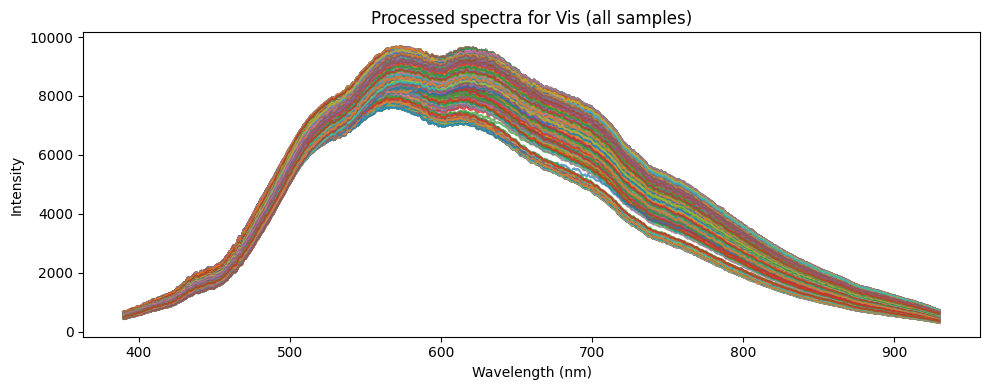

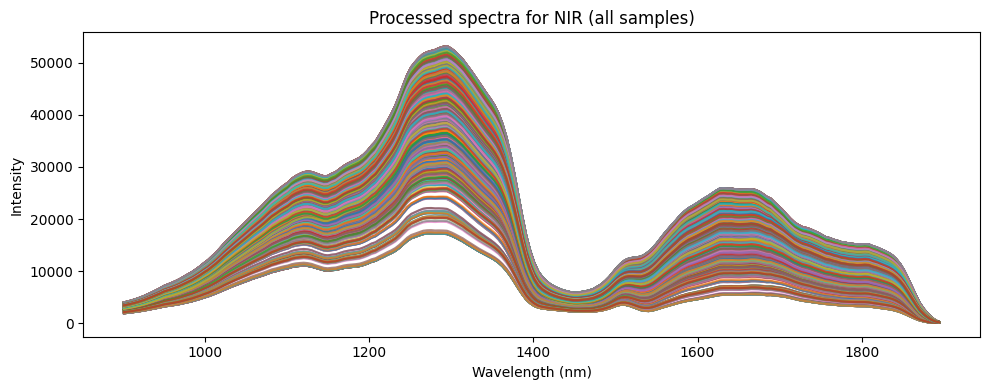

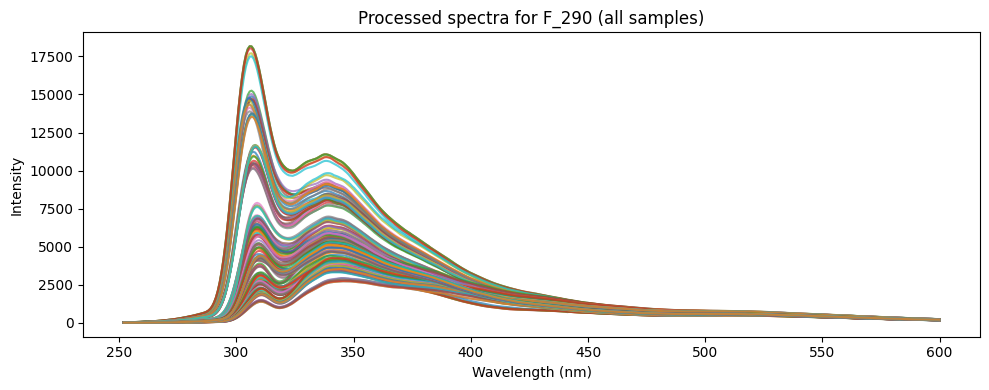

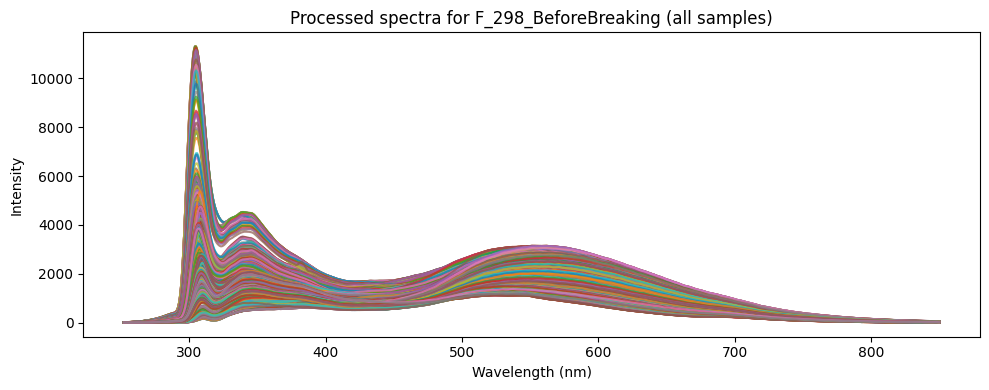

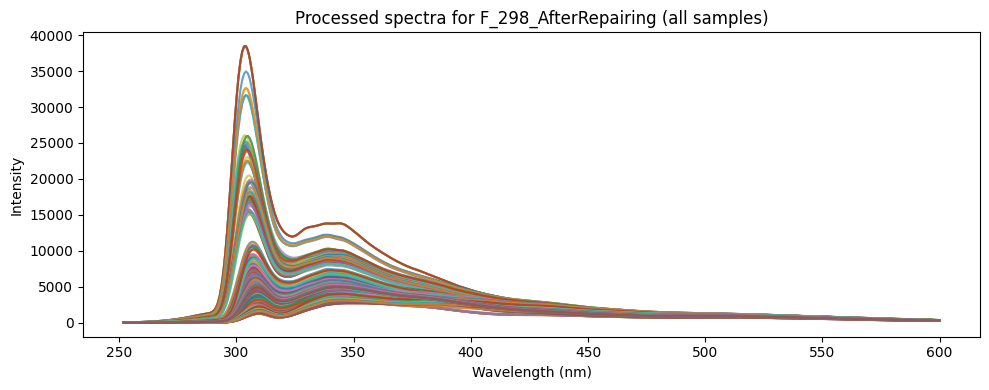

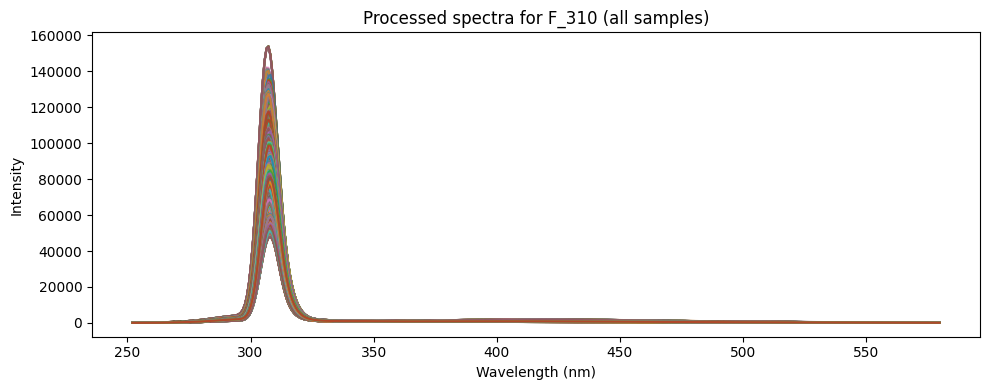

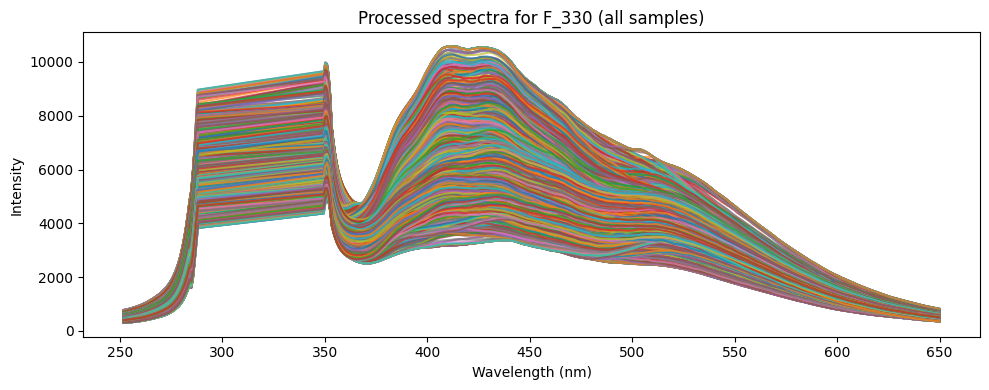

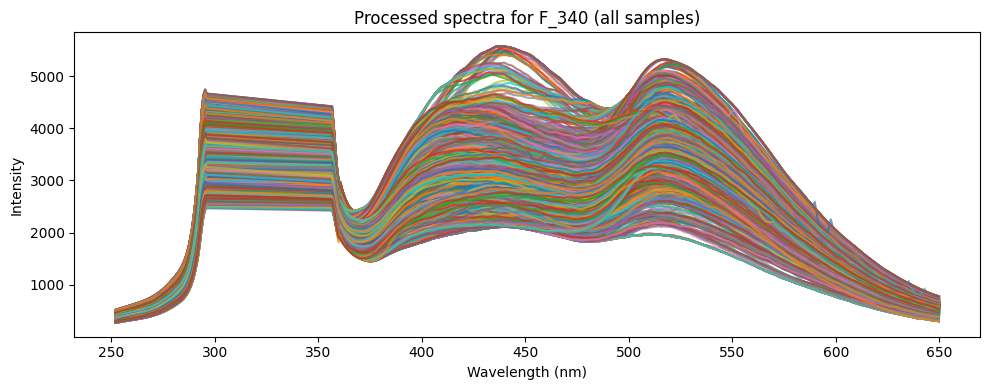

In [ ]:
# Section 6 - Plot Cleaned and Preprocessed Selected Spectra (Optional)

import os
import numpy as np
import matplotlib.pyplot as plt

#Saving Options
save_cleaned_plots  = True      # Put 'False' if you don't want to save the spectra
cleaned_plots_dir   = '/content/drive/MyDrive/Xavi/LW_PLS/Spectra_Cleaned'
os.makedirs(cleaned_plots_dir, exist_ok=True)

# Number of samples to plot per sheet (None = plot all)
plot_first_n = None

def plot_cleaned_spectra(processed_data):
    for sheet, df_all in processed_data.items():
        # Only spectral columns (exclude META_COLS)
        spec_cols = [c for c in df_all.columns if c not in META_COLS]
        wavelengths_sel = np.array(spec_cols, dtype=float)

        # Intensities
        data_sel = df_all[spec_cols].values.astype(float)
        if plot_first_n is not None:
            data_sel = data_sel[:plot_first_n]

        # Plot
        plt.figure(figsize=(10, 4))
        for y in data_sel:
            plt.plot(wavelengths_sel, y, alpha=0.7)
        plt.title(f"Processed spectra for {sheet} ({plot_first_n or 'all'} samples)")
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Intensity")
        plt.tight_layout()

        # Save if requested
        if save_cleaned_plots:
            fname = f"{sheet}_cleaned.png"
            plt.savefig(os.path.join(cleaned_plots_dir, fname), dpi=300)
        plt.show()

plot_cleaned_spectra(d_smoothed)

In [ ]:
# Section 7 - Train/Test Split

from sklearn.model_selection import train_test_split
import pandas as pd

# Train-test split parameters
test_size   = 0.3   # Float [0.0-1.0]: proportion of the dataset to include in the test split
random_seed = 42    # Integer: seed for random number generator to ensure reproducibility

# Column name to predict
Y_COLUMN = 'Fat'

# Covariables used
COVARIABLES = ['Temp', 'DiaAnalysis']  # o [] / None si no quieres usar covariables

def split_data(processed_dict):
    splits = {}
    summary = []

    for sheet, df_all in processed_dict.items():
        df = df_all.copy().reset_index(drop=True)

        # 1) Extraer meta completo
        meta_df = df[META_COLS].copy().reset_index(drop=True)

        # 2) Construir Z (covariables) si se indicaron
        if COVARIABLES:
            Z = df[COVARIABLES].values.astype(float)
        else:
            Z = None

        # 3) Construir X (espectro): todas las columnas menos META_COLS y Y_COLUMN
        spec_cols = [c for c in df.columns
                     if c not in META_COLS + [Y_COLUMN]]
        X = df[spec_cols].values.astype(float)

        # 4) Construir y
        y = df[Y_COLUMN].values

        # 5) Estratificación por combinación Especie–Raza
        df['Strata'] = df['Especie'] + '-' + df['Raza']

        # 6) Split, devolviendo X, y, Z y meta
        if Z is not None:
            X_tr, X_te, y_tr, y_te, Z_tr, Z_te, meta_tr, meta_te = train_test_split(
                X, y, Z, meta_df,
                test_size   = test_size,
                stratify    = df['Strata'],
                random_state= random_seed
            )
        else:
            X_tr, X_te, y_tr, y_te, meta_tr, meta_te = train_test_split(
                X, y, meta_df,
                test_size   = test_size,
                stratify    = df['Strata'],
                random_state= random_seed
            )
            Z_tr = Z_te = None

        # 7) Guardar el split
        splits[sheet] = {
            'X_train':   X_tr,
            'y_train':   y_tr,
            'X_test':    X_te,
            'y_test':    y_te,
            'Z_train':   Z_tr,
            'Z_test':    Z_te,
            'meta_train': meta_tr.reset_index(drop=True),
            'meta_test':  meta_te.reset_index(drop=True)
        }

        # 8) Prints generales
        N, Ntr, Nte = len(y), len(y_tr), len(y_te)
        pct_tr = 100 * Ntr / N
        pct_te = 100 * Nte / N
        print(f"[{sheet}] Total={N}, Train={Ntr} ({pct_tr:.1f}%), Test={Nte} ({pct_te:.1f}%)")

        # 9) Tabla de control por Especie–Raza
        for strata, grp in df.groupby('Strata'):
            especie, raza = strata.split('-',1)
            total = len(grp)
            pct_tot = 100 * total / N
            n_tr = len(meta_tr[meta_tr['Especie']==especie].loc[meta_tr['Raza']==raza])
            n_te = len(meta_te[meta_te['Especie']==especie].loc[meta_te['Raza']==raza])
            summary.append({
                'Hoja':     sheet,
                'Especie':  especie,
                'Raza':     raza,
                'N_total':  total,
                '%_total':  pct_tot,
                'N_train':  n_tr,
                '%_train':  100 * n_tr / total if total>0 else 0,
                '%_train_total':  100 * n_tr / N if N>0 else 0,
                'N_test':   n_te,
                '%_test':  100 * n_te / total if total>0 else 0,
                '%_test_total':   100 * n_te / N if N>0 else 0
            })

    # 10) Mostrar tabla resumen
    resumen_df = pd.DataFrame(summary,
        columns=['Hoja','Especie','Raza','N_total','%_total',
                 'N_train','%_train','%_train_total','N_test',
                 '%_test', '%_test_total'])
    pd.set_option('display.float_format','{:.1f}'.format)
    print("\nResumen de conteos por Especie–Raza:")
    print(resumen_df.to_string(index=False))

    return splits

# 11) Ejecutar sección 7 sobre d_smoothed (o el dict que uses)
splits = split_data(d_smoothed)

[Vis] Total=1394, Train=975 (69.9%), Test=419 (30.1%)
[NIR] Total=1394, Train=975 (69.9%), Test=419 (30.1%)
[F_290] Total=172, Train=120 (69.8%), Test=52 (30.2%)
[F_298_BeforeBreaking] Total=648, Train=453 (69.9%), Test=195 (30.1%)
[F_298_AfterRepairing] Total=306, Train=214 (69.9%), Test=92 (30.1%)
[F_310] Total=1394, Train=975 (69.9%), Test=419 (30.1%)
[F_330] Total=1394, Train=975 (69.9%), Test=419 (30.1%)
[F_340] Total=1394, Train=975 (69.9%), Test=419 (30.1%)

Resumen de conteos por Especie–Raza:
                Hoja Especie              Raza  N_total  %_total  N_train  %_train  %_train_total  N_test  %_test  %_test_total
                 Vis   Cabra MurcianoGranadina      252     18.1      176     69.8           12.6      76    30.2           5.5
                 Vis   Cabra            Tanque      174     12.5      122     70.1            8.8      52    29.9           3.7
                 Vis  Mezcla            Mezcla      156     11.2      109     69.9            7.8      47    

In [ ]:
# Section 8 - Z-score Normalization

from sklearn.preprocessing import StandardScaler

# Preprocessing options
apply_norm_X = True    # Boolean flag: apply z-score normalization to spectra (X)
apply_norm_y = True   # Boolean flag: apply z-score normalization to Y Variable
apply_norm_Z = True    # Boolean flag: apply z-score normalization to covariables (X)

def normalize_splits(splits_dict):
    """
    Normaliza X, y y Z usando medias/desv de entrenamiento.
    Devuelve normalized_splits[sheet] = {
        'X_train','X_test','y_train','y_test',
        'Z_train','Z_test','meta_train','meta_test'
    }
    """
    normalized = {}
    for sheet, sp in splits_dict.items():
        X_tr, X_te = sp['X_train'], sp['X_test']
        y_tr, y_te = sp['y_train'], sp['y_test']
        Z_tr, Z_te = sp['Z_train'], sp['Z_test']
        meta_tr, meta_te = sp['meta_train'], sp['meta_test']

        # 1) Normalizar X
        if apply_norm_X:
            scaler_X = StandardScaler().fit(X_tr)
            X_tr_s = scaler_X.transform(X_tr)
            X_te_s = scaler_X.transform(X_te)
            print(f"[{sheet}] X normalized (train stats)")
        else:
            X_tr_s, X_te_s = X_tr, X_te

        # 2) Normalizar y
        if apply_norm_y:
            scaler_y = StandardScaler().fit(y_tr.reshape(-1,1))
            y_tr_s = scaler_y.transform(y_tr.reshape(-1,1)).ravel()
            y_te_s = scaler_y.transform(y_te.reshape(-1,1)).ravel()
            print(f"[{sheet}] y normalized (train stats)")
        else:
            y_tr_s, y_te_s = y_tr, y_te

        # 3) Normalizar Z
        if apply_norm_Z and Z_tr is not None:
            scaler_Z = StandardScaler().fit(Z_tr)
            Z_tr_s = scaler_Z.transform(Z_tr)
            Z_te_s = scaler_Z.transform(Z_te)
            print(f"[{sheet}] Z normalized (covariables)")
        else:
            Z_tr_s, Z_te_s = Z_tr, Z_te

        # 4) Guardar resultados
        normalized[sheet] = {
            'X_train':   X_tr_s,
            'X_test':    X_te_s,
            'y_train':   y_tr_s,
            'y_test':    y_te_s,
            'Z_train':   Z_tr_s,
            'Z_test':    Z_te_s,
            'meta_train': meta_tr,
            'meta_test':  meta_te
        }

    return normalized

# Ejecutar la normalización sobre el dict splits de la Sección 7
d_normalized = normalize_splits(splits)

[Vis] X normalized (train stats)
[Vis] y normalized (train stats)
[Vis] Z normalized (covariables)
[NIR] X normalized (train stats)
[NIR] y normalized (train stats)
[NIR] Z normalized (covariables)
[F_290] X normalized (train stats)
[F_290] y normalized (train stats)
[F_290] Z normalized (covariables)
[F_298_BeforeBreaking] X normalized (train stats)
[F_298_BeforeBreaking] y normalized (train stats)
[F_298_BeforeBreaking] Z normalized (covariables)
[F_298_AfterRepairing] X normalized (train stats)
[F_298_AfterRepairing] y normalized (train stats)
[F_298_AfterRepairing] Z normalized (covariables)
[F_310] X normalized (train stats)
[F_310] y normalized (train stats)
[F_310] Z normalized (covariables)
[F_330] X normalized (train stats)
[F_330] y normalized (train stats)
[F_330] Z normalized (covariables)
[F_340] X normalized (train stats)
[F_340] y normalized (train stats)
[F_340] Z normalized (covariables)


In [ ]:
# Section 9 - Plot Normalized Spectra (Optional)

import os
import numpy as np
import matplotlib.pyplot as plt

#Saving Options
save_norm_plots  = True      # Put 'False' if you don't want to save the spectra
norm_plots_dir   = '/content/drive/MyDrive/Xavi/LW_PLS/Spectra_Normalized'
os.makedirs(norm_plots_dir, exist_ok=True)

# Number of samples to plot per sheet (None = plot all)
plot_first_n = None

def plot_normalized_spectra(norm_dict, reference_dict):
    """
    norm_dict[sheet]: {
      'X_train','X_test',…,'meta_train','meta_test'
    }
    reference_dict[sheet]: DataFrame original con nombres de columna,
      de él sacamos las longitudes de onda (spec_cols).
    """
    for sheet, sp in norm_dict.items():
        X_tr = sp['X_train']
        X_te = sp['X_test']

        # 1) extraer longitudes desde el DF de referencia
        spec_cols = [c for c in reference_dict[sheet].columns if c not in META_COLS]
        wavelengths = np.array(spec_cols, dtype=float)

        # 2) limitar número de muestras
        data_tr = X_tr if plot_first_n is None else X_tr[:plot_first_n]
        data_te = X_te if plot_first_n is None else X_te[:plot_first_n]

        # 3) dibujar
        fig, ax = plt.subplots(figsize=(10, 4))
        for y in data_tr:
            ax.plot(wavelengths, y, alpha=0.5,
                    label='Train' if 'Train' not in ax.get_legend_handles_labels()[1] else "")
        for y in data_te:
            ax.plot(wavelengths, y, alpha=0.5, linestyle='--',
                    label='Test'  if 'Test'  not in ax.get_legend_handles_labels()[1] else "")

        ax.set_title(f"Normalized spectra for {sheet}")
        ax.set_xlabel("Wavelength (nm)")
        ax.set_ylabel("Intensity (z-score)")

        # leyenda fija fuera
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        plt.tight_layout()
        plt.subplots_adjust(right=0.75)

        # 4) guardar si procede
        if save_norm_plots:
            fname = f"{sheet}_normalized.png"
            fig.savefig(os.path.join(norm_plots_dir, fname), dpi=300)
        plt.show()

# 9.2) Ejecutar sobre d_normalized y usar d_smoothed (o raw_data) como reference_dict
plot_normalized_spectra(d_normalized, d_smoothed)

Output hidden; open in https://colab.research.google.com to view.